In [1]:
%matplotlib inline

## Load SDSS and calculate $F_{\rm bulge}(M_{\ast})$ and $F_{\rm disk}(M_{\ast})$

In [2]:
from empirical_disk_bulge.observations import load_umachine_sdss_complete

sdss = load_umachine_sdss_complete()
mask = sdss['type_mendel13'] != 4
mask *= sdss['deltaBD_mendel13'] <= 1
cut_sdss = sdss[mask]


from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm

_result = sfr_sequence_bulge_disk_fractions_vs_sm(cut_sdss['bt'], 
                                              cut_sdss['sm'], cut_sdss['ssfr'])
np.save('frac_bulge_disk_vs_sm_mendel13', np.array(_result))


## Load `UniverseMachine`

In [3]:
from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.arange(50)
vamock = value_added_mock(load_mock_from_binaries(subvolumes), 250)
print("{0} galaxies in downsampled mock".format(len(vamock)))

Total runtime = 15.51 seconds
108821 galaxies in downsampled mock


In [4]:
from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()
sfr_history = vamock['sfr_history_main_prog']
sm_history = vamock['sm_history_main_prog']

from empirical_disk_bulge.models import disk_in_situ_bulge_ex_situ_decomposition
sm_disk, sm_bulge = disk_in_situ_bulge_ex_situ_decomposition(sfr_history, sm_history, cosmic_age_array, 0.)

smtot = sm_disk + sm_bulge
frac_disk = sm_disk/smtot
vamock['bt'] = 1. - frac_disk


In [5]:
from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm

sm = np.log10(vamock['obs_sm'])
bt = vamock['bt']
ssfr = np.log10(vamock['obs_sfr']/vamock['obs_sm'])

result_model = sfr_sequence_bulge_disk_fractions_vs_sm(bt, sm, ssfr)

In [6]:
_result_from_disk = np.load('frac_bulge_disk_vs_sm_mendel13.npy')
result_from_disk = [_result_from_disk[i, :] for i in range(_result_from_disk.shape[0])]

sm_abscissa, frac_disk_dom_all, frac_bulge_dom_all,\
    frac_disk_dom_sfs, frac_bulge_dom_sfs, \
    frac_disk_dom_gv, frac_bulge_dom_gv, \
    frac_disk_dom_q, frac_bulge_dom_q = result_from_disk

In [7]:
sm_abscissa_model, frac_disk_dom_all_model, frac_bulge_dom_all_model,\
    frac_disk_dom_sfs_model, frac_bulge_dom_sfs_model, \
    frac_disk_dom_gv_model, frac_bulge_dom_gv_model, \
    frac_disk_dom_q_model, frac_bulge_dom_q_model = result_model

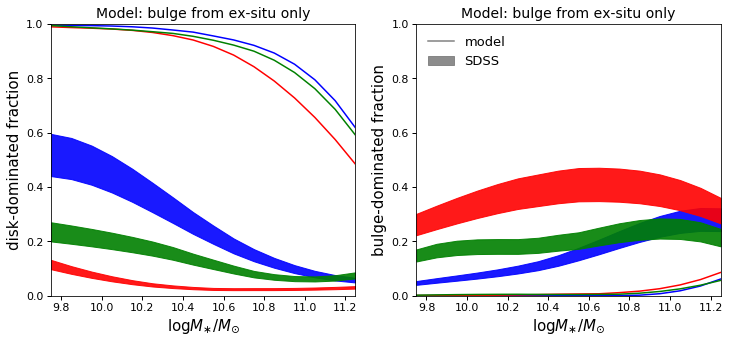

In [16]:
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

a, b = 11, 3

fracerr = 0.15
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_sfs, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_sfs, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='blue', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_gv, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_gv, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='green', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_q, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_q, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='red', alpha=0.9, label='SDSS')

ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_sfs, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_sfs, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='blue', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_gv, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_gv, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='green', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_q, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_q, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='red', alpha=0.9, label='SDSS')

xlabel1 = ax1.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
xlabel2 = ax2.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
ylabel1 = ax1.set_ylabel(r'disk-dominated fraction', size=15)
ylabel2 = ax2.set_ylabel(r'bulge-dominated fraction', size=15)

xmin, xmax = 9.75, 11.25
xlim1 = ax1.set_xlim(xmin, xmax)
xlim2 = ax2.set_xlim(xmin, xmax)
ymin, ymax = 0, 1
ylim1 = ax1.set_ylim(ymin, ymax)
ylim2 = ax2.set_ylim(ymin, ymax)


__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_sfs_model, a, b), 
            color='blue')
__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_q_model, a, b), 
            color='red')
__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_gv_model, a, b), 
            color='green', label='model')

__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_sfs_model, a, b), 
            color='blue')
__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_q_model, a, b), 
            color='red')
__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_gv_model, a, b), 
            color='green', label='model')

title1 = ax1.set_title(r'Model: bulge from ex-situ only', size=14)
title2 = ax2.set_title(r'Model: bulge from ex-situ only', size=14)

legend = ax2.legend(loc=2, fontsize=13)
legend.legendHandles[0].set_color('gray')
legend.legendHandles[1].set_color('gray')

fig.savefig('ex_situ_model_comparison.pdf', 
            bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')
